In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from scipy.signal.windows import dpss
import sys

log2 = 12



# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

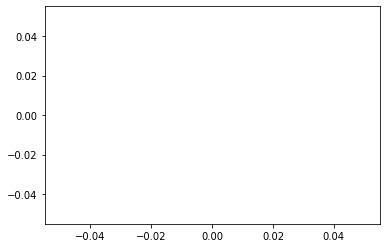

In [2]:
plt.plot()
plt.rcParams['text.usetex'] = True

In [3]:
log_ymin = np.log10(ells[0])
log_ymax = np.log10(ells[-1])


In [5]:
plot_Lambdas = np.arange(25)[::6]


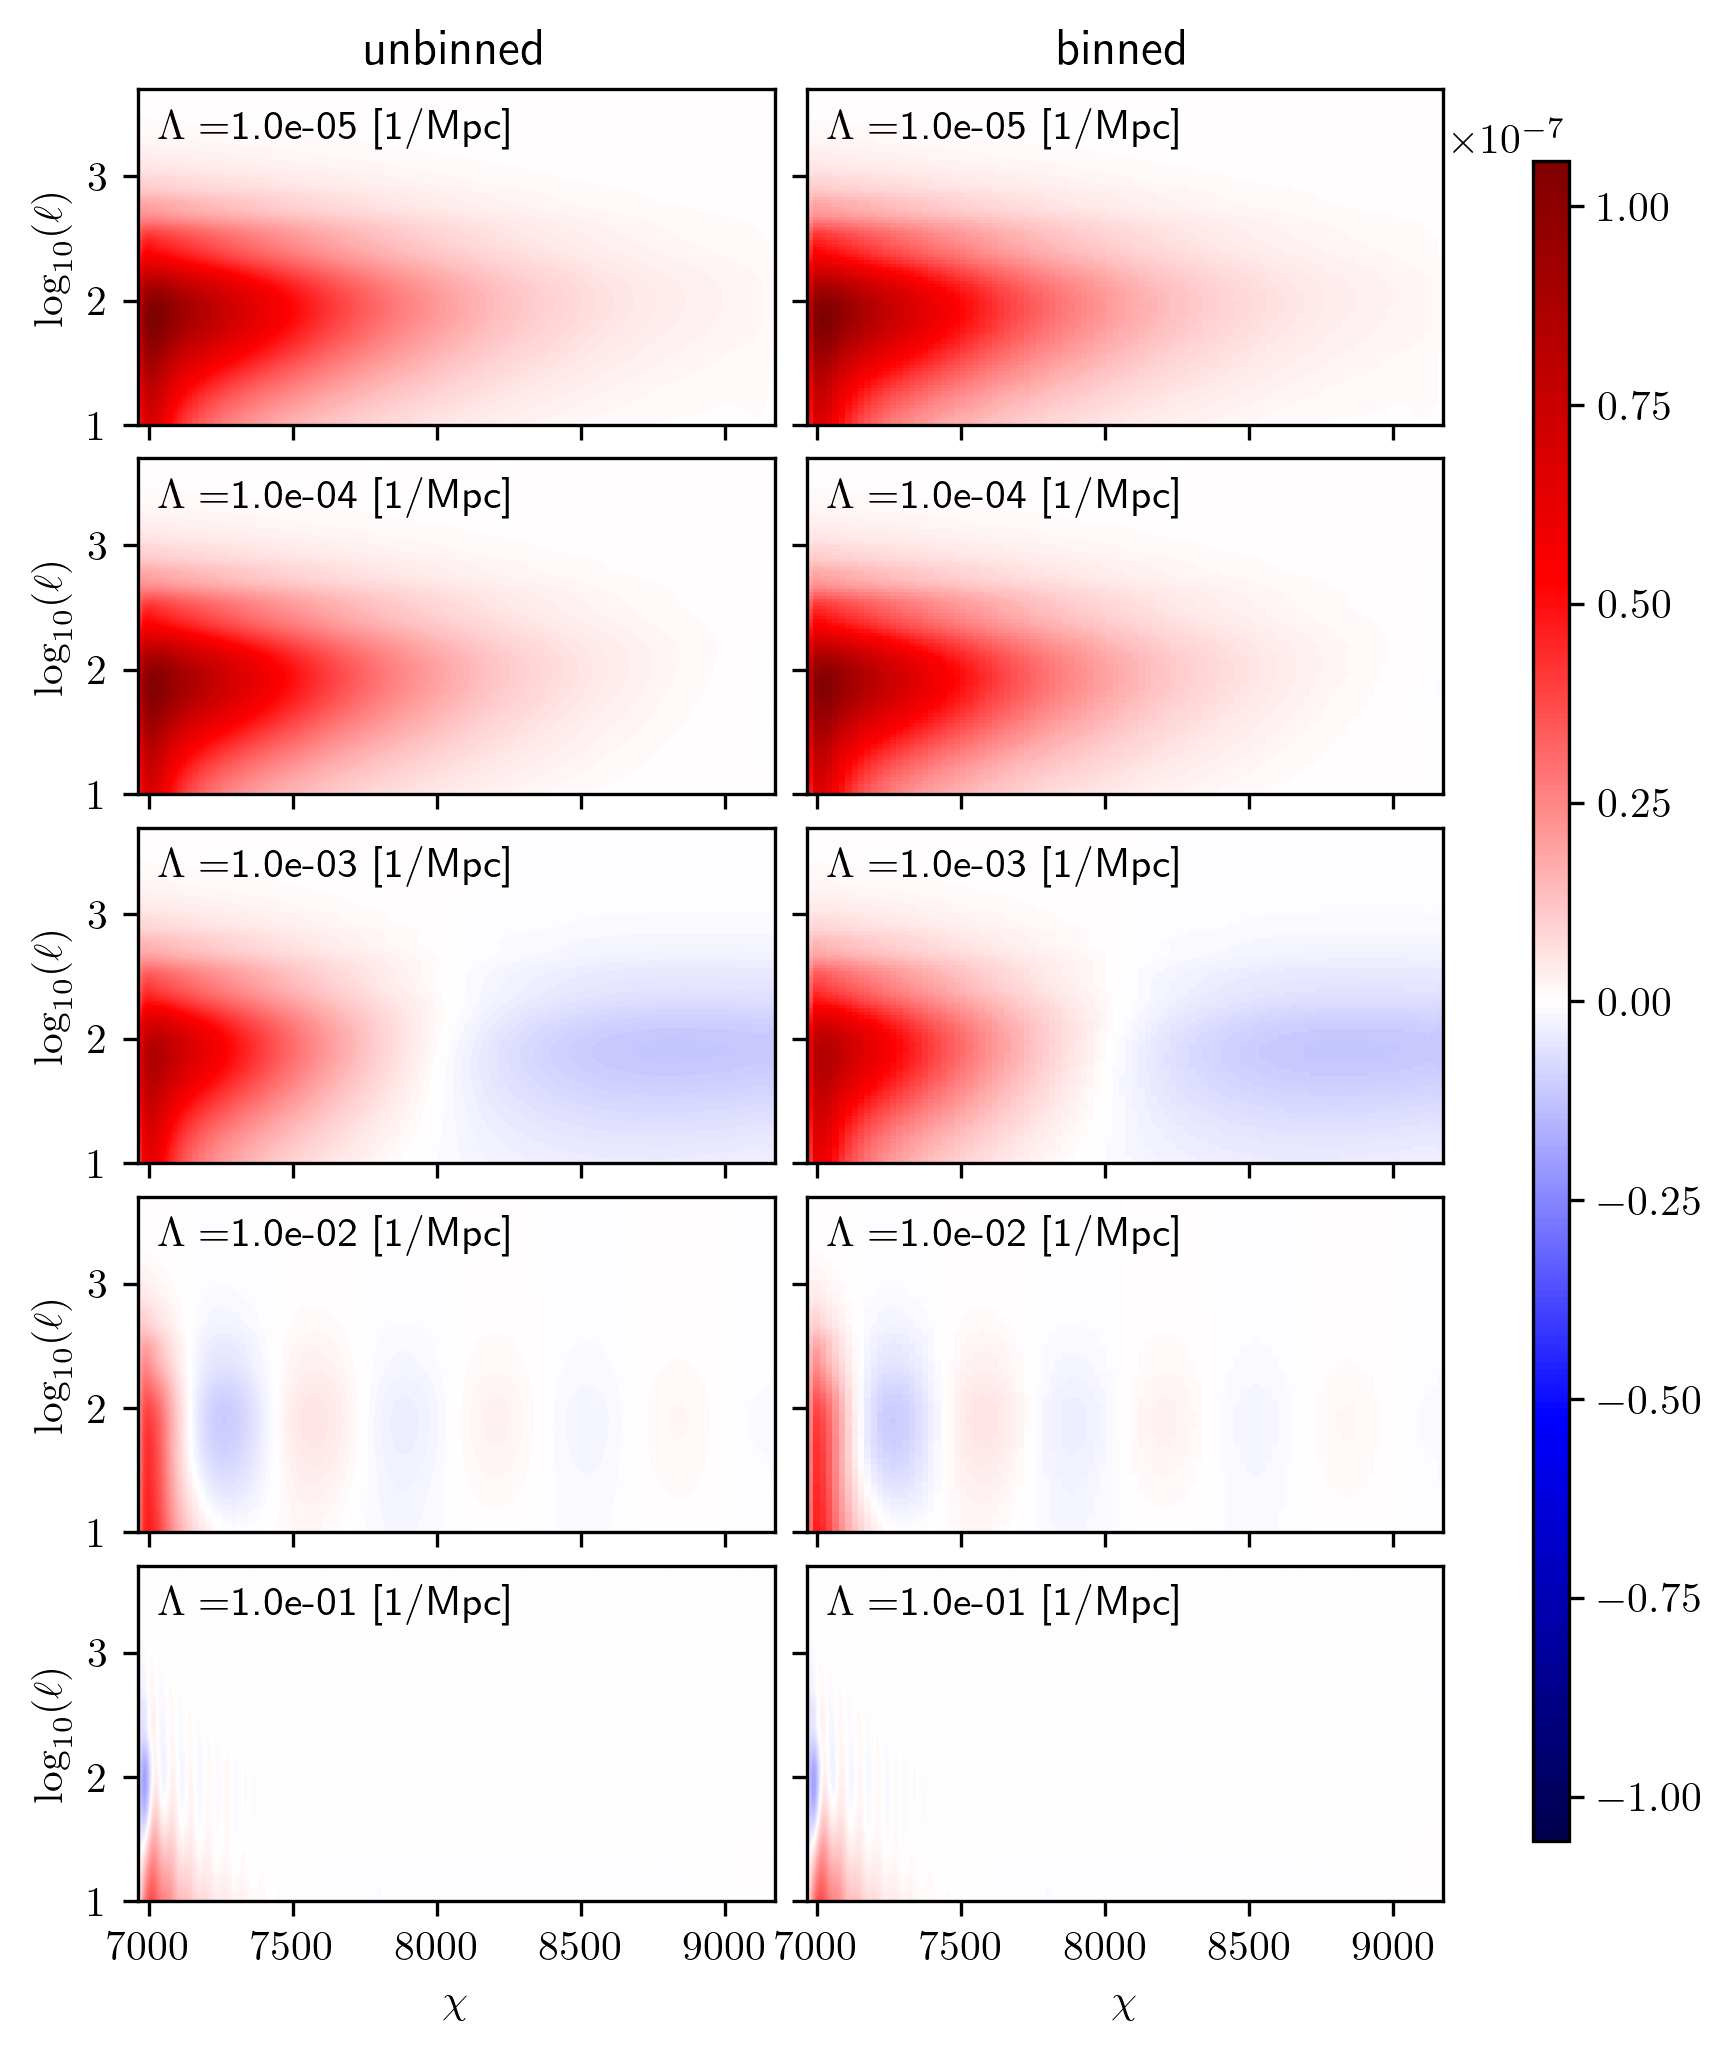

In [6]:
fig, axs = plt.subplots(nrows =len(plot_Lambdas), 
                        ncols = 2, figsize = (6, 8), sharex=True,
                        sharey=True, facecolor = 'w', dpi = 300)
def plot(ax, data, vminmax, title, Lambda):
    # plot data
    im = ax.imshow(data, 
               origin='lower',
              cmap = 'seismic',
              vmin = -vminmax,
              vmax =  vminmax,
               aspect = 'auto',
              extent=[chimin, chimax, log_ymin, log_ymax])

#     cbar = plt.colorbar(im, ticks=[-6e-8, -3e-8,0,3e-8,6e-8])


    ax.text(chimin*(1+0.01), 3.3, '$\Lambda =$%.1e [1/Mpc]'%(Lambda))

for Lambda_idx in plot_Lambdas:
    Lambda = Lambdas[Lambda_idx]
    Ik_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_chi_sample_%d.npy'%(zmin, zmax, log2)
    I_kappa = np.load(Ik_fname)

    external_chis     =  np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 2**log2)
    ILo_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_%d.npy'%(zmin, zmax, Lambda, log2)
    ILo_kappa = np.load(ILo_kappa_fname)
    IHi_kappa = (I_kappa - ILo_kappa).astype(np.float64)
    
    vb = np.max(np.abs(I_kappa))
    plot(ax = axs[Lambda_idx//6][0],
         data = IHi_kappa,
         vminmax = vb,
         title = 'unbinned',
        Lambda = Lambda)
    
    
    nbins = 100
    chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
    chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
    IHi_kappa_binned = np.zeros((len(ells),nbins), dtype=np.float64)
    for i, (left, right) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        idxs = np.where((external_chis > left) & (external_chis <= right))[0]
        IHi_kappa_binned[:, i] = np.sum(IHi_kappa[:, idxs], axis=-1) / len(idxs)
        
    plot(ax = axs[Lambda_idx//6][1],
         data = IHi_kappa_binned,
         vminmax = vb,
         title = 'binned',
        Lambda = Lambda)
    
axs[0][0].set_title('unbinned')
axs[0][1].set_title('binned')

for i in range(len(axs)):
    axs[i][0].set_ylabel(r"$\log_{10}(\ell)$")
    
for i in range(len(axs[-1])):
    axs[-1][i].set_xlabel(r'$\chi$')

fig.subplots_adjust(right=0.85)  # Make space for the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

im = axs[-1][-1].imshow(IHi_kappa, 
               origin='lower',
              cmap = 'seismic',
              vmin = -vb,
              vmax =  vb,
               aspect = 'auto',
              extent=[chimin, chimax, log_ymin, log_ymax])

cbar = fig.colorbar(im, cax=cbar_ax)
plt.subplots_adjust(wspace=0.05, hspace=0.1, right=0.85)
